In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hivprogression/training_data.csv
/kaggle/input/hivprogression/hivprogression_solution.csv
/kaggle/input/hivprogression/test_data.csv


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as st

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('/kaggle/input/hivprogression/training_data.csv')
df_test = pd.read_csv('/kaggle/input/hivprogression/test_data.csv')

In [4]:
df_train.head()

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PatientID  1000 non-null   int64  
 1   Resp       1000 non-null   int64  
 2   PR Seq     920 non-null    object 
 3   RT Seq     1000 non-null   object 
 4   VL-t0      1000 non-null   float64
 5   CD4-t0     1000 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 47.0+ KB


In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PatientID,1000.0,500.50000,288.819436,1.0,250.75,500.5,750.25,1000.0
Resp,1000.0,0.20600,0.404633,0.0,0.00,0.0,0.00,1.0
VL-t0,1000.0,4.29721,0.704780,2.7,3.70,4.3,4.80,6.0
CD4-t0,1000.0,279.63800,198.186712,0.0,132.75,249.0,383.25,1589.0


In [7]:
df_train.isna().sum()

PatientID     0
Resp          0
PR Seq       80
RT Seq        0
VL-t0         0
CD4-t0        0
dtype: int64

In [8]:
print(f"undiagnosed>{np.log(50)}")
print(f"treated and repressed<{np.log(200)}")
print(f"treated and not under control>{np.log(200)}")

undiagnosed>3.912023005428146
treated and repressed<5.298317366548036
treated and not under control>5.298317366548036


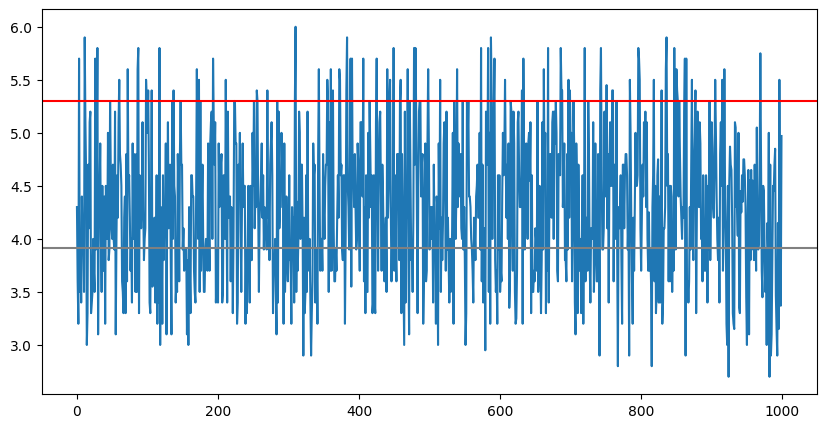

In [9]:
plt.figure(figsize=(10,5))
df_train["VL-t0"].plot();
plt.axhline(np.log(50), color="gray")
plt.axhline(np.log(200), color="red")
plt.show()

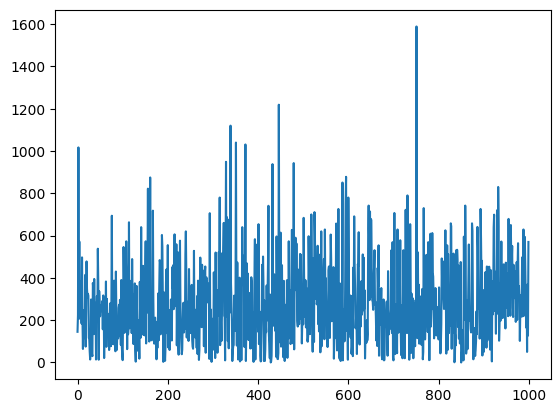

In [10]:
df_train["CD4-t0"].plot();

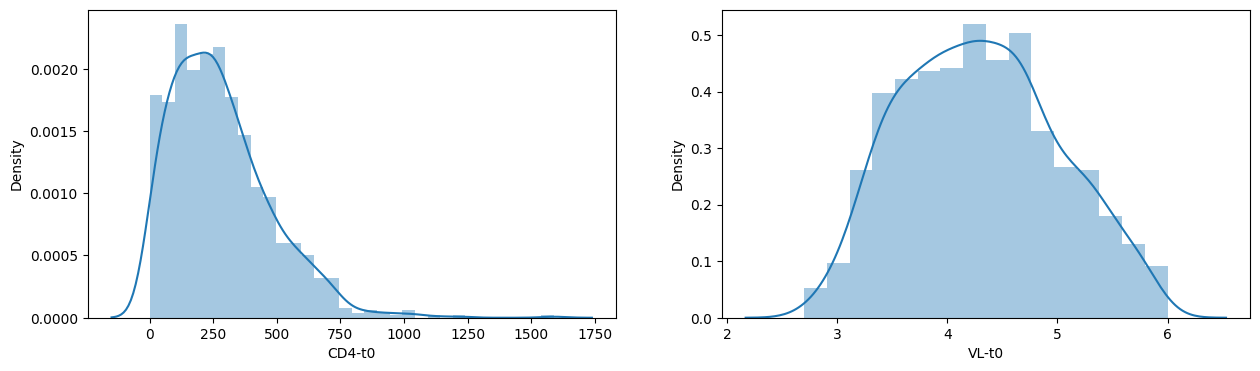

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
sns.distplot(df_train["CD4-t0"], ax=ax1)
sns.distplot(df_train["VL-t0"], ax=ax2)
plt.show()


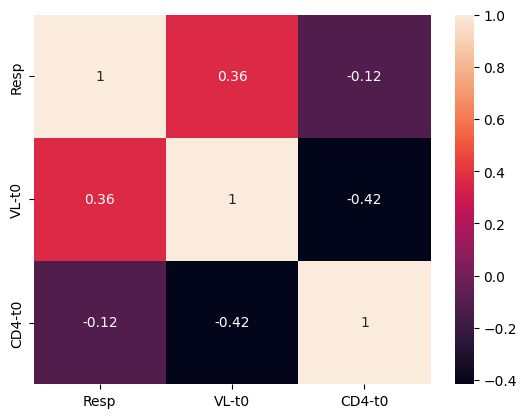

In [12]:
sns.heatmap(df_train[["Resp","VL-t0","CD4-t0"]].corr(),annot=True)
plt.show()

### Model devolopment

#### Transform Data for Model

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.pipeline import Pipeline

numeric_column_select = make_column_selector(dtype_include=np.number)

X = df_train[['VL-t0','CD4-t0']]
y = df_train['Resp']

scale_pipeline = Pipeline([
    ('scale', StandardScaler())
])

preprocess = ColumnTransformer([
    ('scale_pipe', scale_pipeline, make_column_selector(dtype_include=np.number)),
])

X = preprocess.fit_transform(X)
y = df_train['Resp']

#### model traning

In [14]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machines": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "Xgboost": XGBClassifier(),
    "lightgbm": LGBMClassifier()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Doğruluk Puanı: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print()

Logistic Regression Doğruluk Puanı: 0.77
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       156
           1       0.40      0.09      0.15        44

    accuracy                           0.77       200
   macro avg       0.59      0.53      0.51       200
weighted avg       0.70      0.77      0.71       200


K-Nearest Neighbors Doğruluk Puanı: 0.77
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       156
           1       0.43      0.20      0.28        44

    accuracy                           0.77       200
   macro avg       0.62      0.56      0.57       200
weighted avg       0.72      0.77      0.73       200


Support Vector Machines Doğruluk Puanı: 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       156
           1       0.00      0.00      0.00        44

    accuracy                           0.78       200

In [16]:
#Adaboost has the best accuracy score
adb = AdaBoostClassifier()
adb.fit(X_train,y_train)
y_pred = adb.predict(X_test)
accuracy_score(y_test,y_pred)

0.78

In [17]:
X_test1 = df_test[["VL-t0","CD4-t0"]]
y_pred = adb.predict(X_test1)

In [18]:
submissions = pd.DataFrame({'PatientID': np.arange(1,y_pred.shape[0]+1),'ResponderStatus': y_pred})
submissions.to_csv('submission.csv', index=False)